In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import torch
from torchvision.models import resnet50, ResNet50_Weights

# TICES — ResNet50 Weight Analysis

Compares weight statistics across convolutional layers of an untrained (prior) vs pretrained (post) ResNet50. The prior model represents the diffuse LSD state; the post model represents the normal state. Four metrics — abs(weight min), weight max, kurtosis, and total abs(weight) — show that training prunes and concentrates weight magnitude to a select subset of important connections, analogous to how the conscious confines perception to higher-level features.

In [7]:
# load pretrained (post) and untrained (prior) ResNet50
post_model = resnet50(weights=ResNet50_Weights.DEFAULT)
prior_model = resnet50(weights=None)

In [8]:
# extract conv layer weights from both models
def extract_conv_weights(model):
    weights = []
    for module in model.modules():
        if isinstance(module, torch.nn.Conv2d):
            w = module.weight.detach().cpu().numpy().flatten()
            weights.append(w)
    return weights

prior_weights = extract_conv_weights(prior_model)
post_weights = extract_conv_weights(post_model)

print(f"Number of conv layers: {len(prior_weights)}")

Number of conv layers: 53


In [9]:
# compute statistics per layer
def compute_stats(weights_list):
    abs_min = [np.abs(w).min() for w in weights_list]
    weight_max = [np.abs(w).max() for w in weights_list]
    kurt = [stats.kurtosis(w) for w in weights_list]
    total_abs = [np.abs(w).sum() for w in weights_list]
    return abs_min, weight_max, kurt, total_abs

prior_abs_min, prior_max, prior_kurt, prior_total = compute_stats(prior_weights)
post_abs_min, post_max, post_kurt, post_total = compute_stats(post_weights)

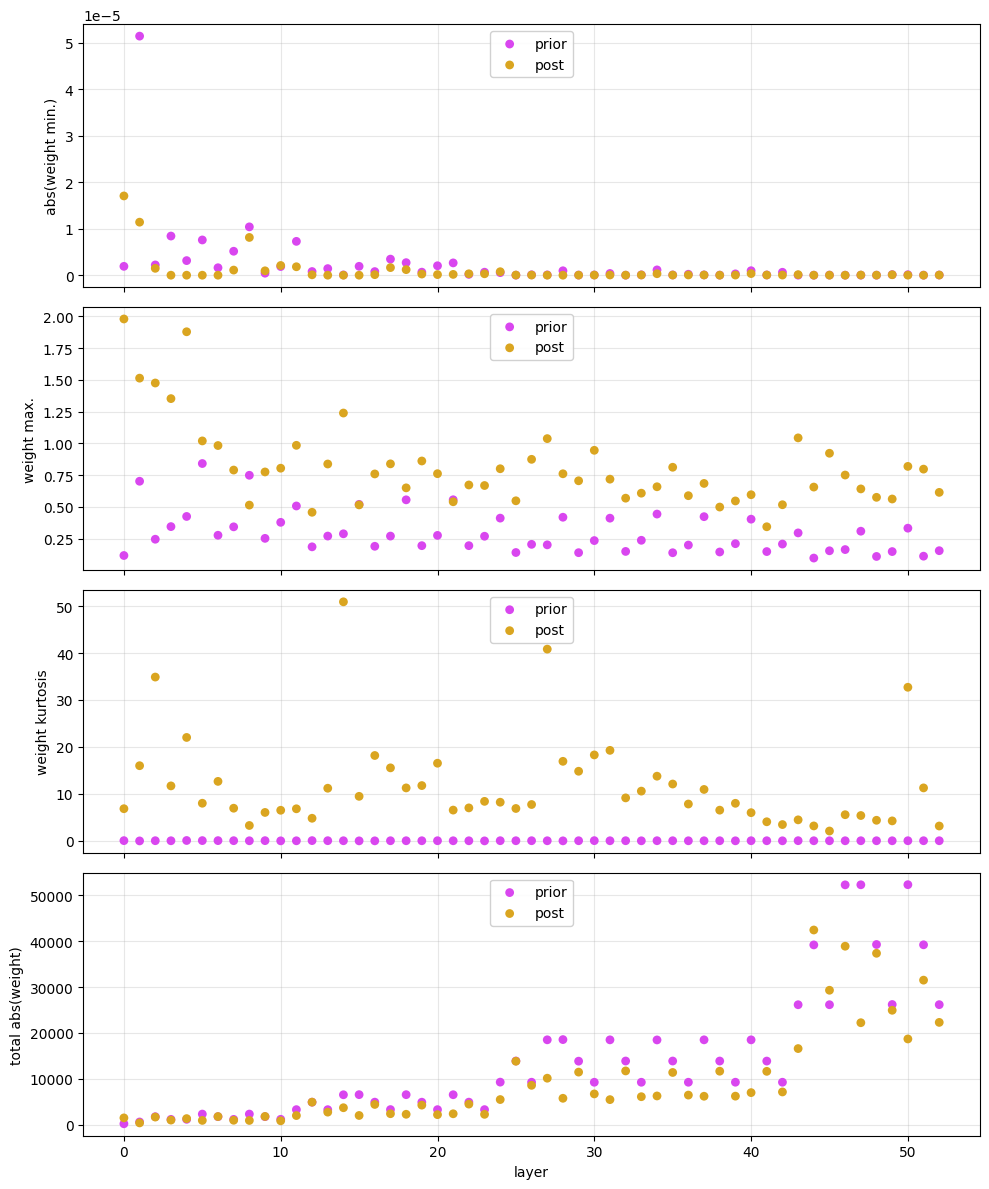

In [10]:
# reproduce Figure 3 from the paper
layers = np.arange(len(prior_weights))

fig, axes = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

metrics = [
    (prior_abs_min, post_abs_min, "abs(weight min.)"),
    (prior_max, post_max, "weight max."),
    (prior_kurt, post_kurt, "weight kurtosis"),
    (prior_total, post_total, "total abs(weight)"),
]

for ax, (prior_vals, post_vals, ylabel) in zip(axes, metrics):
    ax.scatter(layers, prior_vals, color="#D946EF", label="prior", s=40, alpha=1.0, edgecolors="none", zorder=3)
    ax.scatter(layers, post_vals, color="#DAA520", label="post", s=40, alpha=1.0, edgecolors="none", zorder=3)
    ax.set_ylabel(ylabel)
    ax.legend(loc="upper center", framealpha=0.9)
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel("layer")
plt.tight_layout()
plt.show()

**Note:** This figure reproduces the analysis from the paper (Figure 3) using PyTorch's ResNet50 rather than the original TensorFlow/Keras implementation. While the monotonic trends hold — confirming the paper's thesis — exact values may differ due to:

1. **Independent training runs** — the TF and PyTorch pretrained checkpoints were trained separately with different hyperparameters and data augmentation
2. **Different weight initialization** — Keras defaults to Glorot uniform; PyTorch uses Kaiming uniform for conv layers, shifting the prior (untrained) distribution
3. **Layer enumeration order** — shortcut/downsample convolutions may be indexed differently across frameworks
4. **Layer inclusion** — the original code may have included or excluded certain layers (e.g., 1x1 projection shortcuts) differently